# cuQuantum Tensor Network Tutorial

In this tutorial, we will explore the cuQuantum Python API using the [M10 Sycamore circuit](https://ai.googleblog.com/2019/10/quantum-supremacy-using-programmable.html) as an example. 

We chose this problem because it is a great fit for the tensor network method (the single-precision state vector would require 64 PetaBytes of memory) and it is highly entangled creating a challenge for quantum circuit simulators and continues to be studied widely in the Quantum Computing community.

To get the most out of this tutorial, you should have attended the introduction to cuQuantum and tensor networks [presentation](ISC22_cuQuantum_Tensor_Networks.pdf) earlier during this conference where key concepts and algorithms were described.

_Tip: restart kernel and clear output if you have issues in running code due to global state (like import or logging)._

## Setup

Load the Sycamore M10 data and create a circuit using [Quimb](https://quimb.readthedocs.io/en/latest/):

In [ ]:
import quimb.tensor as qtn

name = "data/circuit_n53_m10_s0_e0_pABCDCDAB.qsim"
circ = qtn.Circuit.from_qasm_file(name)

First create a Quimb tensor network representing a random bit string $\mathbf{b}$ of length 53:

In [ ]:
b = qtn.MPS_rand_computational_state(circ.N, seed=12)

def mps_bit_string(mps):
   return ''.join('0' if (a == [[1., 0.]]).all() else '1' for a in mps.arrays)

mps_bit_string(b)

Next, create a Quimb tensor network object resulting from the overlap of the wave function $\large\mathbf{|\: \psi \rangle \equiv U\:|\:\psi_0 \rangle}$ with bit string $\mathbf{b}$, $\large\mathbf{\alpha= \langle b\:|\:\psi \rangle \equiv \langle b\:|\:U\:|\:\psi_0 \rangle}$:

In [ ]:
tn = circ.psi & b
tn

Plot the Quimb tensor network:

In [ ]:
tn.graph(iterations=25, color=circ.psi.site_tags, legend=False, figsize = (5, 5))

Simplify the circuit in-place and cast to single precision:

In [ ]:
output_inds = ()
tn.full_simplify_(output_inds=output_inds).astype_('complex64')

As you can see, full simplification has dramatically reduced the number of tensors in the network. We will also see the impact of using the unsimplified network with cuQuantum later.

Now visualize the simplified Quimb tensor network:

In [ ]:
tn.graph(iterations=25, color=circ.psi.site_tags, legend=False, figsize = (5, 5))

## Network Definition

The [Einstein summation ("einsum") convention](https://en.wikipedia.org/wiki/Einstein_notation) is an elegant way of specifying common tensor operations, and the original notation has been [generalized](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) to allow operations not initially supported. The generalized einsum expression along with the input tensors is the interface used by cuQuantum to concisely capture the graph structure of the tensor network.

Create an einsum expression from the Quimb tensor network:

In [ ]:
inputs, output, _ = tn.get_inputs_output_size_dict(output_inds=output_inds)
expr = ','.join(inputs) + '->' + output
operands = tn.arrays

## cuQuantum in a Nutshell

Import cuQuantum:

In [ ]:
from cuquantum import *

Evaluate the probability amplitude $\large\mathbf{\alpha= \langle b\:|\:\psi \rangle \equiv \langle b\:|\:U\:|\:\psi_0 \rangle}$ by contracting the network:
<a id='initial_run'></a>

In [ ]:
%time alpha = contract(expr, *operands)

In [ ]:
alpha

In [ ]:
abs(alpha)**2

_That's all it takes._ You've used cuQuantum to contract the tensor network and evaluate the probability amplitude where $\large\mathbf{|\alpha|^2}$ is the probability of obtaining the bitstring $\mathbf{b}$. Note that while the input tensors are NumPy `ndarray`s on the CPU, the contraction happens on the GPU. The result however is of the same type as the input tensors, so it is also a NumPy `ndarray`.

Now let's turn logging on to see the operations happening inside cuTensorNet during the `contract()` call. 

The default logger is the root logger, though a custom logger object conforming to the Python [logging module](https://docs.python.org/3/library/logging.html) interface  can also be provided. Different log levels can be specified corresponding to the extent of information needed.

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(levelname)-8s %(message)s', force=True)
logging.disable(logging.NOTSET)    # reset logging to default.

contract(expr, *operands)

The main operations are: 

1. defining the network,
2. finding an optimal contraction path, and
3. performing the contraction.

Each operation consists of a set of interrelated subtasks as depicted in the figure below. You are able to customize the operations by providing desired options.


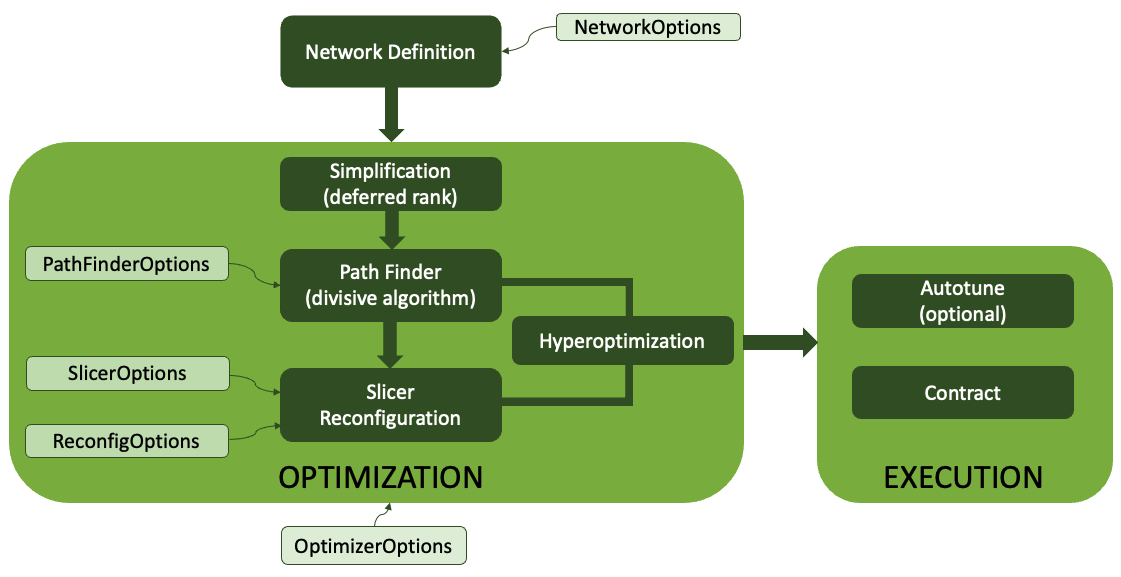

We will look at the main operations in detail shortly. Now that you have an idea of what is happening behind the scene, disable logging to reduce clutter:

In [ ]:
logging.disable()

## Optimization

Compute the contraction path using opt_einsum to obtain metrics such as total number of floating point operations (FLOPs) and largest intermediate tensor size (for memory considerations) for reference:

In [ ]:
import opt_einsum as oe
path, info = oe.contract_path(expr, *operands)
f"opt_einsum FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

### Default Options

Now let's compute the path using cuQuantum with the default options. We'll use the [function-call API](https://docs.nvidia.com/cuda/cuquantum/python/api/cuquantum.html#python-functions):

In [ ]:
path, info = contract_path(expr, *operands)
f"Default: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

As you can see, the default cuQuantum path is more than 3 _orders of magnitude_ cheaper than the opt_einsum path and the largest intermediate is over 100 times smaller. Note that there are aspects of randomness in the algorithm, so you will see a different result for each run. We'll discuss this shortly as well.

### Path Finder Options

First disable reconfiguration to see the effect on the cost of the computed path. We'll use the options API systematically in this example. In later examples, we will see equivalent forms of providing the options directly.

In [ ]:
reconfig_opts = ReconfigOptions(num_iterations = 0)
optimizer_opts = OptimizerOptions(reconfiguration = reconfig_opts)
path, info = contract_path(expr, *operands, optimize = optimizer_opts)
f"No reconfiguration: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

Without reconfiguration, the cost of the path has increased by about 2 orders of magnitude. Reconfiguration, which iteratively improves the path quality through a sequence of local modifications, is clearly important to obtaining a high-quality path. _We will keep reconfiguration disabled to prevent it from masking the impact as we experiment with the path finder options_.

Let's check the effect of setting the divisive algorithm (graph partitioning) parameters on the quality of the computed path. Experience has shown that one such key parameter is the _imbalance factor_ and we set it to a value of 160 here which is a "slight" change since the default is 200.  Note that we disable reconfiguration using a `dict` interface here to illustrate the flexibility of the API.

In [ ]:
imbalance_factor = 160 
pathfinder_opts = PathFinderOptions(imbalance_factor = imbalance_factor)
optimizer_opts = OptimizerOptions(path = pathfinder_opts, reconfiguration = {'num_iterations' : 0}) 
path, info = contract_path(expr, *operands, optimize = optimizer_opts)
f"No reconfiguration, imbalance factor = {imbalance_factor}: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

Let's try a different value of the imbalance factor, say 820:

In [ ]:
imbalance_factor = 820 
optimizer_opts = OptimizerOptions(path = {'imbalance_factor' : imbalance_factor}, reconfiguration = {'num_iterations' : 0}) 
path, info = contract_path(expr, *operands, optimize = optimizer_opts)
f"No reconfiguration, imbalance factor = {imbalance_factor}: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

With an imbalance factor of 820, the path is about an order of magnitude less expensive than with an imbalance factor of 160.

### Reconfiguration Options

While the graph partitioning options such as the imbalance factor have a significant effect on the FLOP count, it is clear that reconfiguration seems to be key in lowering the FLOP count of the path for this problem. 

In [ ]:
%time path, info = contract_path(expr, *operands)
f"Default reconfiguration: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

Now let's change the number of iterations for reconfiguration from the default of 500 to 100:

In [ ]:
num_iter = 100  
optimizer_opts = OptimizerOptions(reconfiguration = {'num_iterations' : num_iter})
%time path, info = contract_path(expr, *operands, optimize = optimizer_opts)
f"Reconfiguration with {num_iter} iterations: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

Reducing the number of iterations typically increases the FLOP count but decreases the optimizer runtime and vice-versa. While reconfiguration never increases the FLOP count of the candidate path computed by the divisive algorithm, the reconfiguration parameters should be chosen to balance the time required to find a path with the reduction in the cost of the path.

Now let's set the number of leaves for reconfiguration from 8 to 64:

In [ ]:
num_leaves = 64 
optimizer_opts = OptimizerOptions(reconfiguration = {'num_leaves' : num_leaves})
%time path, info = contract_path(expr, *operands, optimize = optimizer_opts)
f"Reconfiguration with {num_leaves} leaves: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

While increasing the number of leaves to reconfigure typically reduces the FLOPs it is a tradeoff against pathfinder runtime.

### Slicer Options

This problem does not trigger slicing since the memory required (2-4 GB from the log above) is well under the available memory in a modern GPU. However, if desired, slicing can be explicitly requested (to perform the execution in parallel, for example):

In [ ]:
min_slices = 16
optimizer_opts = OptimizerOptions(slicing = {'min_slices' : min_slices})
path, info = contract_path(expr, *operands, optimize = optimizer_opts)
f"Slicing with a minimum of {min_slices} slices: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

And get information on which modes are sliced, along with the sliced extent: 

In [ ]:
info.slices

As a tip, note that while the sliced extent is 1 for the sliced modes when cuQuantum does the slicing, [user-specified slices](https://docs.nvidia.com/cuda/cuquantum/python/api/generated/cuquantum.OptimizerOptions.html#cuquantum.OptimizerOptions.slicing) can have any sliced extent that evenly divides the extent of the corresponding mode.

An alternate way to force slicing is to specify a smaller memory limit to the network as part of the [network options](https://docs.nvidia.com/cuda/cuquantum/python/api/generated/cuquantum.contract_path.html#cuquantum.contract_path). 

### Hyperoptimization

To conclude this section, instead of experimenting with the parameters as we did above, we can use the cuQuantum hyperoptimizer to explore the parameter space over `N` samples and choose the best path from among these.

Let's try hyperoptimization with 16 samples:

In [ ]:
samples = 16
path, info = contract_path(expr, *operands, optimize = {'samples' : samples, 'threads' : 4})
f"Hyperoptimization with {samples} samples: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

While the results will vary unless the number of samples is large enough, we can see that even with as few as 16 samples the hyperoptimizer has been able to find a better path than we have done so far.

## Execution

So far we've been looking at different options for computing the path. Now let us use the computed path and perform the contraction to evaluate the amplitude.

In [ ]:
%time contract(expr, *operands, optimize = {'path' : path})

Compare the wall time with that of the [initial run](#initial_run), and observe that this time corresponds to only that required for executing the contraction operation since we have provided the path.

## Repeatability in Path Optimization 

Let's take a detour and discuss repeatability of the computed path. The results from the pathfinder algorithm are deterministic if the random seed is set and only 1 thread is used with hyperoptimization.

In [ ]:
samples = 4 
seed = 0x256
path, info = contract_path(expr, *operands, optimize = {'samples' : samples, 'seed' : seed, 'threads' : 1}) 
f"Hyperoptimization with {samples} samples using seed {seed} and one thread, run #1: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

In [ ]:
path, info = contract_path(expr, *operands, optimize = {'samples' : samples, 'seed' : seed, 'threads' : 1}) 
f"Hyperoptimization with {samples} samples using seed {seed} and one thread, run #2: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

As a reminder, we can find the best path and perform the contraction in a single step (as in the [first example](#initial_run) of this tutorial). We can also return the path that was used.

In [ ]:
alpha, (path, info) = contract(expr, *operands, optimize = {'samples' : samples, 'threads' : 1}, return_info=True)
f"Hyperoptimization with {samples} samples: FLOPs = {info.opt_cost:.3e}, largest intermediate = {info.largest_intermediate:.3e} elements"

In [ ]:
f"Probability amplitude for bitstring {mps_bit_string(b)} = {alpha}"

## Executing Multiple Contractions

Let's try sampling another amplitude while reusing the same path determined above. We can reuse the path computed above since the network topology remains the same.

In [ ]:
b = qtn.MPS_rand_computational_state(circ.N, seed=42)
tn = circ.psi & b
tn.full_simplify_(output_inds=output_inds).astype_('complex64')

alpha = contract(expr, *tn.arrays, optimize = {'path' : path})
f"Probability amplitude for bitstring {mps_bit_string(b)} = {alpha}"

## Effect of Simplification

Finally, let's try to evaluate the amplitude for the original bitstring _without_ using `Quimb` simplification.

In [ ]:
b = qtn.MPS_rand_computational_state(circ.N, seed=12)
tn = circ.psi & b
tn.astype_('complex64')

Create the einsum expression:

In [ ]:
inputs, output, size_dict = tn.get_inputs_output_size_dict(output_inds=output_inds)
expr = ','.join(inputs) + '->' + output

Enable logging again and contract the network:

In [ ]:
logging.disable(logging.NOTSET)
alpha = contract(expr, *tn.arrays)
logging.disable()
f"Network without Quimb simplification: probability amplitude for bitstring {mps_bit_string(b)} = {alpha}"

Note that the FLOP count of the network without simplification is about the same as the FLOP count with full simplification. This is because cuQuantum performs deferred rank-simplification as part of the path optimization step.

## Afternotes

In this tutorial, we explored cuQuantum using the coarse-grained or function call APIs, which offer drop-in replacement functionality for the main tensor network operations: finding an optimal contraction order and performing the contraction. cuQuantum also offers these operations as methods on a [Network](https://docs.nvidia.com/cuda/cuquantum/python/api/generated/cuquantum.Network.html#cuquantum.Network) object, referred to as the fine-grained API. While both the coarse-grained and fine-grained APIs offer the same functionality, the latter is more efficient for repeated contractions on the same network. 

cuQuantum supports NumPy, CuPy, and PyTorch tensor operands. The Einstein summation expression can be specified in string or interleaved format, and implicit and explicit forms are supported. Broadcasting, including ellipsis expansion, is supported. In addition to the optimizer options that we focused on in this tutorial, options can be specified for the network as well as for execution (stream specification, for example). You can also provide your own memory allocator and more.

Please refer to the [documentation](https://docs.nvidia.com/cuda/cuquantum/python/index.html) and explore the [samples](https://github.com/NVIDIA/cuQuantum/tree/main/python/samples) on GitHub to learn more.